In [2]:
import gc
import os
import re
import cv2
import copy
import shutil
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [28]:
imgFreq = {}
#,'19V','19PCT','22V','37V','37H','37PCT','91H','91V','91PCT','150H','183_1H','183_3H','183_7H'
#,'CPAC','EPAC','IO','SHEM','WPAC'
#,'kmeans','fuzzykmeans'
freqList = ['150H']
regList = ['ATL']
funList = ['agglo']

In [29]:
'''
for reg in regList:
    imgFreq[reg] = {}
    for freq in freqList:
        imgFreq[reg][freq] = {}
        path = "..\\..\\AllFrequencies\\"+reg+"\\"+freq+"\\"
        for fun in funList:
            funpath = path + fun +"\\"
            imgFreq[reg][freq][fun] = {}
            
            ls1 = os.listdir(funpath)
            for test in ls1:
                imgFreq[reg][freq][fun][test] = {}
                cl_nums = os.listdir( funpath+test )
                for cl_num in cl_nums:
                    imgFreq[reg][freq][fun][test][cl_num] = pd.read_csv(funpath+test+"\\"+cl_num+"\\testInfo.csv")
'''
imgFreq = {}
for reg in regList:
    imgFreq[reg] = {}
    for freq in freqList:
        imgFreq[reg][freq] = {}
        path = "..\\..\\AllFrequencies\\"+reg+"\\"+freq+"\\"
        for fun in funList:
            funpath = path + fun +"\\"
            imgFreq[reg][freq][fun] = {}
            ls1 = os.listdir(funpath)
            for test in ls1:
                testpath = funpath+test+"\\"
                imgFreq[reg][freq][fun][test] = {}
                cl_nums = os.listdir( testpath )
                
                
                for cl_num in cl_nums:
                    cl_path = testpath+cl_num+"\\"
                    '''
                    if os.path.isfile( cl_path+"sig_testInfo.csv" ) == False:
                        sC = SignificantCluster(pd.read_csv( cl_path+"testInfo.csv" ), cl_path)
                        sC.Create_Sig_Cluster_DF()
                        del sC
                    '''
                    imgFreq[reg][freq][fun][test][cl_num] = pd.read_csv(cl_path+"sig_testInfo.csv")

ATL 150H agglo


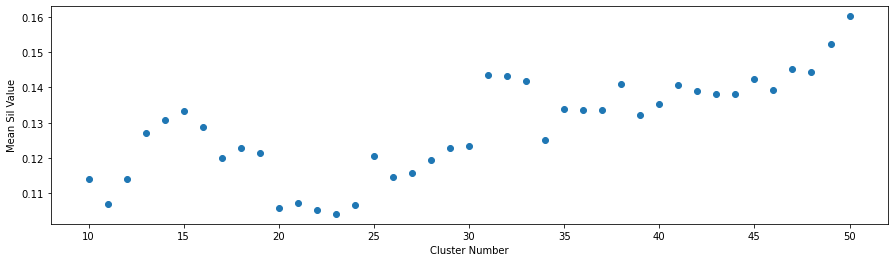

In [47]:
#for reg in regList:
#    for freq in freqList:
reg = 'ATL'
freq= '150H'
fun = 'agglo'


i=0
for test,v1 in imgFreq[reg][freq][fun].items():
    print(reg,freq,fun)
    total_sil_mean = []
    total_k = []
    for cl_num,df in v1.items():
        total_sil_mean.append(np.mean( df.SilhouetteVal ))
        total_k.append(int(cl_num))
    
    plt.figure(figsize=(15,4))
    plt.ylabel("Mean Sil Value")
    plt.xlabel("Cluster Number")
    plt.scatter(total_k,total_sil_mean)
    i+=1
    break
plt.save_fig("")
    

In [19]:
plt.close()

### Reading TestInfo for each TestResult
TestInfo.csv store all the necessary information after the clustering<br/>
is done on the specific Region and Frequencies.

In [ ]:
for reg in regList:
    imgFreq[reg] = {}
    for freq in freqList:
        imgFreq[reg][freq] = {}
        path = "..\\..\\AllFrequencies\\"+reg+"\\"+freq+"\\"
        for fun in funList:
            funpath = path + fun +"\\"
            imgFreq[reg][freq][fun] = {}

            #ls = os.listdir(funpath)
            #for test in ls:
            #imgFreq[reg][freq][fun][] = pd.read_csv(funpath+test+"\\testInfo.csv")
            for root,dirs,files in os.walk(funpath):
                imgFreq[reg][freq][fun][test] = pd.read_csv(root+"\\testInfo.csv")
            

### Test Result Class
Function to Paste Images into Each Cluster<br />
Function to Remove those Pastes Images<br />
Function to Create Composite Images ( Mean of all images in a Significant cluster )<br />
Function to Create Histograms of Cluster Label and Intensity Number<br />

In [ ]:
def MakeDir(path):
    if os.path.isdir(path) == False:
        os.mkdir(path)
        return True
    return False

colorbar = {}
colorbar['19PCT']  = [270,320]
colorbar['19V'] = [185,295]
colorbar['19H'] = [110,290]
colorbar['22V'] = [205,290]
colorbar['37PCT']  = [250,310]
colorbar['37V'] = [205,290]
colorbar['37H'] = [135,290]
colorbar['91PCT']  = [135,300] 
colorbar['91V'] = [130,295]
colorbar['91H'] = [130,295]
colorbar['150H'] = [105,295]
colorbar['183_1H'] = [125,270]
colorbar['183_3H'] = [105,280]
colorbar['183_7H'] = [105,290]

class TestResults():
    global colorbar
    def __init__(self,df,path,freq):
        self.mDf = df
        self.mColorbarLimit = colorbar[freq]
        self.mPath = path #+ "SilValue_"+ str(self.mMinSilVal) + "\\"
        self.mSignificantCluster = self.FindSignificantCluster()
    
    def __del__(self):
        print(self.mPath)
        del self.mDf
        del self.mColorbarLimit
        del self.mPath
        del self.mSignificantCluster
    
    # Finding Significant Cluster by finding which intensity (t_no) passes the criteria
    def FindSignificantCluster(self):
        t_no_label = self.mDf.T_No.unique()
        t_no_label.sort()
        cluster_labels = self.mDf.ClusterLabel.unique()
        cluster_labels.sort()
        
        # Length and Mean Sil of all T_No
        t_no_dict = {}
        for t_no in t_no_label:
            t_no_dict[t_no] = ( len(self.mDf[ self.mDf.T_No==t_no ]),np.mean( self.mDf[ self.mDf.T_No==t_no ].SilhouetteVal ) )
        
        significant_cluster_list = {}
        for cl in cluster_labels:
            # Get cl(1......k(clusters)) Cluster datafame and calculate its mean
            cl_mean = np.mean( self.mDf[ self.mDf.ClusterLabel==cl ].SilhouetteVal )
            
            for t_no in t_no_label:
                # Find Dataframe of Cluster and unique t_no
                # Gets total images found in T_No and CL
                cl_t_no_len = len( self.mDf[(self.mDf.ClusterLabel==cl) & (self.mDf.T_No==t_no)] )
                
                # Total images found should be more than 5% of T_No images
                if cl_t_no_len > (0.05)*t_no_dict[t_no][0]:
                    
                    # Cluster sil value must be greater than T_No sil
                    if cl_mean > t_no_dict[t_no][1]:
                        if significant_cluster_list.get(cl) == None:
                            significant_cluster_list[cl] = []
                        significant_cluster_list[cl].append(t_no)

        return significant_cluster_list
    
    def Composite_Images(self,w=360):
        folderName = "Composite_Images"
        if not MakeDir(self.mPath+folderName):
            #print(self.mSignificantCluster)
            return 
        
        for cL,t_no_list in self.mSignificantCluster.items():
            totalLen = 0
            comp_img = np.zeros((w,w,3))
            maxSilImage = 0
            maxSilVal = -2 # Min is -1
            for t_no in t_no_list:
                cl_t_no_df = self.mDf[ (self.mDf.ClusterLabel == cL) & (self.mDf.T_No == t_no) & (self.mDf.SilhouetteVal > 0)]
                if (len(cl_t_no_df) == len(self.mDf)):
                    print("Somethings Wrong")
                
                totalLen += len(cl_t_no_df)
                for i,r in cl_t_no_df.iterrows():
                    # Read ImageFiles and Not Considering Alpha Value just BGR is considered
                    img_cv = cv2.imread(r.FileName) 
                    img_cv = cv2.resize(img_cv, (w,w) )
                    if r.SilhouetteVal > maxSilVal:
                        maxSilVal = r.SilhouetteVal
                        maxSilImage = img_cv
                    comp_img += img_cv
                    
            if totalLen != 0:
                comp_img /= totalLen
                self.Create_Image( maxSilImage, self.mPath+folderName+"\\"+str(cL)+"_"+"MaxSil_Image.png" ) 
                self.Create_Image( comp_img.astype(np.uint8), self.mPath+folderName+"\\"+str(cL)+"_"+str(totalLen)+".png" )
            
    def Create_Image(self,arr,path):
        plt.imshow(cv2.cvtColor(arr, cv2.COLOR_BGR2RGB),cmap="jet_r")
        plt.clim(self.mColorbarLimit[0],self.mColorbarLimit[1])
        plt.colorbar()
        plt.axis('off')
        plt.tight_layout(pad=0)
        plt.savefig(path,bbox_inches = 'tight', pad_inches = 0)
        plt.close()
            
    # Coping Images from MyCreatedData to The cluster where it belongs for this testCase
    def Paste_Images(self):
        for cL,t_no_list in self.mSignificantCluster.items():
            MakeDir(self.mPath+str(cL))
            
            for t_no in t_no_list:
                cl_t_no_df = self.mDf[ (self.mDf.ClusterLabel == cL) & (self.mDf.T_No == t_no) ]
                if (len(cl_t_no_df) == len(self.mDf)):
                    print("Somethings Wrong")
                    
                for i,r in cl_t_no_df.iterrows():
                    cL_path = self.mPath+str(r.ClusterLabel)+"\\"
                    imgName = r.FileName.split("\\")[8]
                    
                    # Original Image Name in new path
                    actualFile = cL_path+imgName
                    
                    # Copied at the cluster label where it belongs
                    shutil.copy( r.FileName,cL_path )
                    
                    # Renaming the copied file : This helps us to understand which intensity belongs to a particular image
                    # Old name : imgName
                    # New name : imgIntensity_imgName
                    temp_t_no= str(t_no).replace(".","-")
                    renameFile = cL_path+temp_t_no+"_"+imgName[:25]+"_"+"{:.2f}".format(r.SilhouetteVal)+".png"
                    try:
                        os.rename(actualFile,renameFile)
                    except WindowsError:
                        os.remove(renameFile)
                        os.rename(actualFile,renameFile)
        
    def Remove_Pasted_Images(self):
        for root, dirs, files in os.walk(self.mPath):
            if "Cluster_Label" in root or  "T_No_Label" in root:
                print(os.path.join(root))
                #shutil.rmtree(os.path.join(root))   
            #"Composite_Images" in root or 
            for name in files:
                if "SSMIS" in name and ".png" in name:
                    print(os.path.join(root, name))
                    #os.remove(os.path.join(root, name))
                    
    def Create_Histogram(self):
        cL_path = self.mPath+"Cluster_Label\\"
        if not MakeDir(cL_path):
            return
        cL_path+="\\"
        
        tno_path = self.mPath+"T_No_Label\\"
        if not MakeDir(tno_path):
            return
        tno_path+="\\"
        
        cluster_labels = self.mDf.ClusterLabel.unique()
        
        distr = {}
        distr["cluster_img"] = {}
        distr["cluster_sil"] = {}
        distr["t_no_img"] = {}
        distr["t_no_sil"] = {}
        plot_var = {}
        plot_var["cluster_img"] = ["T_No - per cluster", min(cluster_labels),max(cluster_labels),cL_path]
        plot_var["t_no_img"] = ["Cluster Label - per T_No", 0,9,tno_path]
        plot_var["cluster_sil"] = ["Sil Value - per cluster", -1,1,cL_path]
        plot_var["t_no_sil"] = ["Sil Value - per T_No", -1, 1,tno_path]
        
        for cL,t_no_list in self.mSignificantCluster.items():
            distr["cluster_img"][cL] = []
            distr["cluster_sil"][cL] = []
            for t_no in t_no_list:
                if distr["t_no_img"].get(t_no) == None:
                    distr["t_no_img"][t_no] = []
                if distr["t_no_sil"].get(t_no) == None:
                    distr["t_no_sil"][t_no] = []
                    
                distr["cluster_img"][cL] += list ( self.mDf[ (self.mDf.ClusterLabel == cL) & (self.mDf.T_No == t_no) ].T_No )
                distr["t_no_img"][t_no] += list ( self.mDf[ (self.mDf.ClusterLabel == cL) & (self.mDf.T_No == t_no) ].ClusterLabel )
                
                distr["cluster_sil"][cL] += list ( self.mDf[ (self.mDf.ClusterLabel == cL) & (self.mDf.T_No == t_no) ].SilhouetteVal )
                distr["t_no_sil"][t_no] += list ( self.mDf[ (self.mDf.ClusterLabel == cL) & (self.mDf.T_No == t_no) ].SilhouetteVal )
        
        for label_name, v1 in distr.items():
            for number, lst in v1.items():
                plt.xlim( plot_var[label_name][1], plot_var[label_name][2] )
                plt.xlabel( plot_var[label_name][0] )
                plt.ylabel( "Img Distribution" )
                plt.hist(lst)
                plt.savefig(plot_var[label_name][3]+label_name[len(label_name)-3:]+"_"+str(number)+"_"+str(len(lst))+".png")
                plt.close()
        
        del distr
        del plot_var

### Analyzing the Results

In [ ]:
#reg = 'CPAC'
#freq = '91PCT'
#fun = 'agglo'
#test = 'Test_0'
#df = imgFreq[reg][freq][fun][test]
#for freq in freqList:
for reg in regList:
    for freq in freqList:
        for fun in funList:
            for test,df in imgFreq[reg][freq][fun].items():
                path = "..\\..\\AllFrequencies\\"+reg+"\\"+freq+"\\"+fun+"\\"+test+"\\"
                tR = TestResults(df,path,freq)
                tR.Remove_Pasted_Images()
                #tR.Composite_Images()
                #tR.Remove_Pasted_Images()
                #tR.Paste_Images()
                del tR

In [ ]:
plt.hist([1,1.5,2,2,2,2,2])

In [ ]:
plt.show()

In [ ]:
'''

for fun,v1 in imgFreq[reg][freq].items():
    for test,df in v1.items():

print( fun, test )
        mean_sil = np.mean( df.SilhouetteVal )
        print( mean_sil, len ( df[ df.SilhouetteVal > mean_sil] ), len(df) )
        

for fun,v1 in imgFreq[reg][freq].items():
    for test,df in v1.items():
        mean_sil = np.mean( df.SilhouetteVal )
        print( fun,test, mean_sil, len ( df[ df.SilhouetteVal > mean_sil] ), len(df) )
'''
my_dict = {}
for fun in funList:
    for test,df in imgFreq[reg][freq]["new_data"][fun].items():
        
        path = "..\\..\\AllFrequencies\\"+reg+"\\"+freq+"\\"+fun+"\\"+test+"\\"
        
        cluster_labels = df.ClusterLabel.unique()
        cluster_labels.sort()
        for cL in cluster_labels:
            my_dict[cL] = {}
            
            cluster_df = copy.deepcopy( df[ df.ClusterLabel == cL ] )
            
            my_dict[cL]["All"] = np.mean(cluster_df.SilhouetteVal)
            
            t_no_labels = cluster_df.T_No.unique()
            t_no_labels.sort()
            for t_no in t_no_labels:
                t_no_df = copy.deepcopy( cluster_df[ cluster_df.T_No == t_no ] )
                my_dict[cL][t_no] = np.mean(t_no_df.SilhouetteVal)
        
        
        break
    break
        #for val in silValues:
        #tR = TestResults(df,path,val)
        
            #tR.Silhouette_Graph(fun+test)
            
            #break
            #tR.Paste_Images()
            #tR.Move_Cluster_Folder()
            #tR.Composite_Images()
            #tR.Create_Histogram_Images()
            #tR.Remove_Pasted_Images()

pd.DataFrame(my_dict)

cluster_bin_0_mean_sil_0.069018 < mean_silhouetteval_0.0_which_are_in_cluster_0 # ---
cluster_bin_0_mean_sil_0.069018 < mean_silhouetteval_0.0_which_are_in_all_clusters # Amanda


In [ ]:
def Create_Histogram_Images(self):
        cluster_labels = self.mDf.ClusterLabel.unique()
        t_no_labels = self.mDf.T_No.unique()
        
        # Creating Cluster_Label Folder
        cL_path = self.mPath+"Cluster_Label_"+ str(self.mMinSilVal)
        if not MakeDir(cL_path):
            return
        cL_path+="\\"

        # Creating T_No Folder 
        tno_path = self.mPath+"T_No_Label_" +str(self.mMinSilVal)
        if not MakeDir(tno_path):
            return
        tno_path+="\\"
        
        # Each graph depicts how each cluster is distributed amoung a particular intensity
        for t_no in t_no_labels:
            x = copy.deepcopy( self.mDf[ self.mDf.T_No == t_no ] )  
            plt.xlim(min(cluster_labels),max(cluster_labels))
            plt.xlabel("Cluster_Label - per each T_No")
            plt.ylabel("No_of_Images")
            plt.hist(x.ClusterLabel)
            plt.savefig(tno_path+str(t_no)+"_"+str(len(x))+".png")
            plt.close()

        # Each graph depicts how the intensity is distributed among a particular cluster
        for cL in cluster_labels:
            x = copy.deepcopy( self.mDf[ self.mDf.ClusterLabel == cL ] )
            plt.xlim(0,9)
            plt.xlabel("T_No - per each cluster") # Text for X-Axis
            plt.ylabel("No_of_Images")
            plt.hist(x.T_No)
            plt.savefig(cL_path+str(cL)+"_"+str(len(x))+".png")
            plt.close()
    
    
    
    
    def Silhouette_Graph(self,test):
        cluster_labels = self.mDf.ClusterLabel.unique()
        plt.xlabel("Silhouette Value") # Text for X-Axis
        plt.ylabel("No of Images")
        plt.hist(self.mDf.SilhouetteVal)
        plt.savefig(test+".png")
        plt.close()
        
        
        '''
        # Each graph depicts how the silhouette is distributed among a particular cluster
        for cL in cluster_labels:
            x = copy.deepcopy( self.mDf[ self.mDf.ClusterLabel == cL ] )
            plt.xlabel("Silhouette Value") # Text for X-Axis
            plt.ylabel("No of Images")
            plt.hist(x.SilhouetteVal)
            plt.savefig(str(cL)+".png")
            plt.close()
        '''
    
    

        
    def Move_Cluster_Folder(self):
        cluster_labels = self.mDf.ClusterLabel.unique()
        newFolder = self.mPath + "SilValue_" + str(self.mMinSilVal)
        for root, dirs, files in os.walk(self.mPath):
            if "Cluster_Label_"+str(self.mMinSilVal) in root or "Composite_Images_"+str(self.mMinSilVal) in root or "T_No_Label_"+ str(self.mMinSilVal) in root:
                try:
                    shutil.move(root, newFolder)        
                except:
                    print("Already Exists: "+root)

In [ ]:
testList = ['Test_10','Test_12','Test_14','Test_16']

fig, ax = plt.subplots( nrows=len(freqList)*len(regList)*len(funList)*len(testList), ncols=2, figsize=(15, 95))
fig.text(0.5, 0.04, 'Silhouette Value', ha='center')
fig.text(0.04, 0.5, 'No of Images', va='center', rotation='vertical')

i=0
for reg in regList:
    for freq in freqList:
        for test in testList:
            for fun in funList:
                j=0
                for old_or_new in old_or_new_list:
                    df = imgFreq[reg][freq][old_or_new][fun][test]
                    cluster_labels = df.ClusterLabel.unique()
                    t_no_labels = df.T_No.unique()
                    
                    msg = fun+" "+test+ "\n"
                    msg += " Mean SilhouetterVal : "+str(np.mean(df.SilhouetteVal)) + "\n"
                    msg += " Total Images : "+ str(len(df)) 
                    #for t_no in t_no_labels:
                    #msg += "Mean T_No Bin " + str(t_no) + " : " + str(np.mean( df.SilhouetteVal[ df.T_No == t_no ] ) ) + "\n"
                    
                    ax[i,j].hist(df.SilhouetteVal)
                    ax[i,j].set_title(msg)
                    j+=1
                i+=1
fig.savefig('full_figure.png')

In [ ]:
original_df = pd.read_csv('..\\ImagesPerFreq\\ATL_91.csv')
original_df = original_df[ original_df.Area > 0.95 ]

In [ ]:
origi_t_no_label = original_df.T_No.unique()
for origi_t_no in origi_t_no_label:
    temp_origi_df = copy.deepcopy( original_df[ original_df.T_No == origi_t_no ] )
    path = "Images\\"+str(origi_t_no)
    MakeDir(path)
    path+="\\"
    for i,r in temp_origi_df.iterrows():
        shutil.copy( r.FileName,path )

In [ ]:
reg = 'ATL'
freq = '91'
fun = 'agglo'
test = 'Test_10'

path = "..\\..\\AllFrequencies\\"+reg+"\\"+freq+"\\Old_data\\"+fun+"\\"+test
print(path)
old_df = pd.read_csv(path+"\\testInfo.csv")
cluster_labels = old_df.ClusterLabel.unique()
plt.xlabel("Silhouette Value") # Text for X-Axis
plt.ylabel("No of Images")
plt.hist(old_df.SilhouetteVal)
print(np.mean(old_df.SilhouetteVal))

In [ ]:
'''            
for reg in regList:
    for freq in freqList:
        for fun in funList:
            for test,df in imgFreq[reg][freq][fun].items():   
                path = "..\\..\\AllFrequencies\\"+reg+"\\"+freq+"\\"+fun+"\\"+test+"\\"
                tR = TestResults(df,path)
                tR.Composite_Images()
                tR.Create_Histogram_Images()
                print(path)
                #tR.Remove_Pasted_Images()
'''

'''
1470 for 0.0
937 for 0.0 in CL==1

875 for 0.1
793 for 0.1 in CL==1
'''
reg = 'ATL'
freq = '91'
fun = 'fuzzykmeans'
test = 'Test_12'
df = imgFreq[reg][freq][fun][test]
path = "..\\..\\AllFrequencies\\"+reg+"\\"+freq+"\\"+fun+"\\"+test+"\\"
tR = TestResults(df,path)
tR.Remove_Pasted_Images()

#apple = copy.deepcopy( df[df.SilhouetteVal > 0.1]  )
#apple
#tR = TestResults(df,path,)
#tR.Composite_Images()
#tR.Create_Histogram_Images()


### Extra Code

#cv2.imread("..\\..\\MyCreatedData\\5\\ATL\\29\\F16\\19\\20051123T113200_SSMIS_F16.png")
'''

#RemovePastedImagesFrom(imgFreq,'ATL','19','agglo','Test_0')
for reg in regList:
    for freq in freqList:
        for fun in funList:
            for test,df in imgFreq[reg][freq][fun].items():
                RemoveImages(reg,freq,fun,test)
                break
            break
        break
    break

In [ ]:
for reg in regList:
    for freq in freqList:
        for fun in funList:
            path = "..\\..\\AllFrequencies\\"+reg+"\\"+freq+"\\"+fun+"\\Test_14\\"
            PasteImages( imgFreq[reg][freq][fun][0], path )
            
'''reg = 'ATL'
freq = '19H'
fun = 'kmeans'
'''

In [ ]:
temp = imgFreq["ATL"]["91"]["agglo"][0][ imgFreq["ATL"]["91"]["agglo"][0].ClusterLabel == 2 ]
temp[ temp.SilhouetteVal > 0.1 ]

In [ ]:
imgFreq[reg][freq][fun][0]

In [ ]:
#for reg in regList:
    #for freq in freqList:

reg = 'ATL'
freq = '19'
path = "..\\..\\AllFrequencies\\"+reg+"\\"+freq+"\\"+"agglo\\Test_14\\"
PasteImages( imgFreq[reg][freq]["agglo"][0], path )


Creating a Zip file of all the specific folders

In [ ]:
from zipfile import ZipFile
reg = 'ATL'
freq = '91'
zipObj = ZipFile(reg+"_"+freq+"_agglo_test_14.zip", 'w')
path = "..\\..\\AllFrequencies\\"+reg+"\\"+freq+"\\"+"agglo\\Test_14\\"
for folderName, subfolders, filenames in os.walk(path):
    for filename in filenames:
        #create complete filepath of file in directory
        filePath = os.path.join(folderName, filename)
        print(filePath)
        zipObj.write(filePath)
zipObj.close()

In [ ]:
from zipfile import ZipFile

for reg in regList:
    zipObj = ZipFile(reg+'agglo_test_14.zip', 'w')
    for freq in freqList:
        path = "..\\..\\AllFrequencies\\"+reg+"\\"+freq+"\\"+"agglo\\Test_14\\"
        for folderName, subfolders, filenames in os.walk(path):
            for filename in filenames:
                #create complete filepath of file in directory
                filePath = os.path.join(folderName, filename)
                zipObj.write(filePath)
    zipObj.close()

Code Below aims at finding common images among multiple frequencies

In [ ]:
def Test( df ):
    df = copy.deepcopy(df[df.SilhouetteVal > 0])
    imgCol = []
    for i,r in df.iterrows():
        imgCol.append( r.FileName.split("\\")[9]  )
    df['ImgName'] = imgCol 
    return df

def CompareTest( df1, df2 ):
    df = df1.merge(df2, left_on='ImgName', right_on='ImgName')
    
    return pd.DataFrame({"ImgName":df.ImgName})

In [ ]:
finalDf = {}
for reg in regList:
    finalDf[reg] = Test( imgFreq[reg][freqList[0]]['agglo'][0] )
    for i in range(1,len(freqList)):
        finalDf[reg] = CompareTest( finalDf[reg], Test(imgFreq[reg][freqList[i]]['agglo'][0]) )

In [ ]:
finalDf['WPAC']

In [ ]:
df1 = Test( imgFreq['ATL']['19H']['kmeans'][9] )
df2 = Test( imgFreq['ATL']['91H']['kmeans'][9] )
df3 = Test( imgFreq['ATL']['150H']['kmeans'][9] )
df4 = Test( imgFreq['ATL']['183_1H']['kmeans'][9] )

df_imgName = CompareTest(df1,df2)
df_imgName = CompareTest(df_imgName, df3)
df_imgName = CompareTest(df_imgName, df4)

df1 = df1.merge( df_imgName, left_on='ImgName', right_on='ImgName' )
df2 = df2.merge( df_imgName, left_on='ImgName', right_on='ImgName' )
df3 = df3.merge( df_imgName, left_on='ImgName', right_on='ImgName' )
df4 = df4.merge( df_imgName, left_on='ImgName', right_on='ImgName' )

In [ ]:
def LabelAndSill(df,silVal, maxLabel):
    dr= df[ df.T_No == silVal ]
    print("-------------------------")
    for i in range(maxLabel):
        print(len( dr[ dr.ClusterLabel == i] ) )
    ''' 
    j=0
    while j <9.5:
        dr=  df[ df.T_No == j ]
        maxLab = -1
        maxVal = -1
        for i in range(maxLabel):
            if len(dr[dr.ClusterLabel == i]) > maxVal:
                maxVal = len(dr[dr.ClusterLabel == i])
                maxLab = i

        print(j,maxVal,maxLab )
        #dr[dr.ClusterLabel == maxLab]
        j+=0.5
    '''

In [ ]:
reg = 'ATL'
freq = '183_1H'
fun = 'kmeans'
j = 9
path = "..\\..\\AllFrequencies\\"+reg+"\\"+freq+"\\"+fun+"\\Test_"+str(j)+"\\"
for i,r in df4.iterrows():
    tNo_path = path+str(r.ClusterLabel)+"\\"+str(r.T_No)
    if os.path.isdir(tNo_path) == False:
        os.mkdir(tNo_path)
    shutil.copy( r.FileName,tNo_path )
    


In [ ]:
from matplotlib import pyplot as plt
import matplotlib.image as mpimage

w=10
h=10
fig=plt.figure(figsize=(8, 8))
columns = 3
rows = 7
for i in range(1, columns*rows +1):
    img = np.random.randint(10, size=(h,w))
    fig.add_subplot(rows, columns, i)
    plt.imshow(img)
plt.show()

In [ ]:
reg = 'ATL'
freq = '19H'
fun = 'kmeans'
test = 9
df = imgFreq[reg][freq][fun][test]
df = df[ df.SilhouetteVal>0.0 ]


'''
imgCol = []
for i,r in df.iterrows():
    imgCol.append( r.FileName.split("\\")[9]  )
df['ImgName'] = imgCol
'''



In [ ]:
dr = df[ df.T_No == 1.0 ]
dr[ dr.ClusterLabel == 0 ].FileName.iloc[3]

In [ ]:
'''
def Ans(df):
    
    uniqueId = sorted(list(df.ClusterLabel_x.unique()))
    for label in uniqueId:
        tno[label] = {}
        df1 = df.T_No[df.ClusterLabel == label]
        t1 = list(df1)
        i=0
        while i <9.5:
            tno[label][i] = t1.count(i)
            i+=0.5
    
    newDf = pd.DataFrame(tno)
    print(newDf)


df = df[ df.Sil]

'''


    
    '''imgCol = []
    for i,r in df3.iterrows():
        imgCol.append( r.FileName.split("\\")[9]  )
    df3['ImgName'] = imgCol   
    
    if (df.T_No_x == df.T_No_y).all():
        if (df.T_No_x == df.T_No).all():
            print("aplee")
    
            
    
    
    
    return df
    '''    
    
    

    '''
    label1 = {}
    for i,r in t1.iterrows():
        if label1.get(r.ClusterLabel) == None:
            label1[r.ClusterLabel] = []
        label1[r.ClusterLabel].append([r.FileName, r.SilhouetteVal, r.T_No])
    
    label2 = {}
    for i,r in t2.iterrows():
        if label2.get(r.ClusterLabel) == None:
            label2[r.ClusterLabel] = []
        label2[r.ClusterLabel].append([r.FileName, r.SilhouetteVal, r.T_No])
    
    for k1,v1 in label1.items():
        for k2,v2 in label2.items():
            
            #v1 and v2 are the lists of rows for a particular label
            count=0
            for l1 in v1:
                for l2 in v2:
                    if l1[0] == l2[0]:
                        count+=1
            print(k1,k2,count)
    '''

In [ ]:
df1 = imgFreq['ATL']['150H']['agglo'][6]
df1 = df1[df1.SilhouetteVal > 0]

In [ ]:
newdf1 = df1.T_No[ df1.ClusterLabel == 4]
t1 = list(newdf1)
i=0
while i <9.5:
    print(i, t1.count(i))
    i+=0.5
print(t1)   

In [ ]:
import pandas as pd

In [ ]:
df = pd.read_csv("temp.csv")

In [ ]:
df [ (df.Method == "agglo") & (df.Freq == "91PCT")]

In [ ]:
for i in range(11):
    print( len( df1[ (df1['ClusterLabel']==i) ] ) )

for i in range(7):
    print( len( df[ (df['ClusterLabel_x']==i) ] ) )
    
for i in range(7):
    print( len( imgFreq['ATL']['91H']['fuzzykmeans'][4][ (imgFreq['ATL']['91H']['fuzzykmeans'][9]['ClusterLabel']==i) ] ) )